Running on device: cuda


100%|██████████| 792M/792M [00:36<00:00, 21.6MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 8.62MB/s]


Train: 2944 | Val: 736


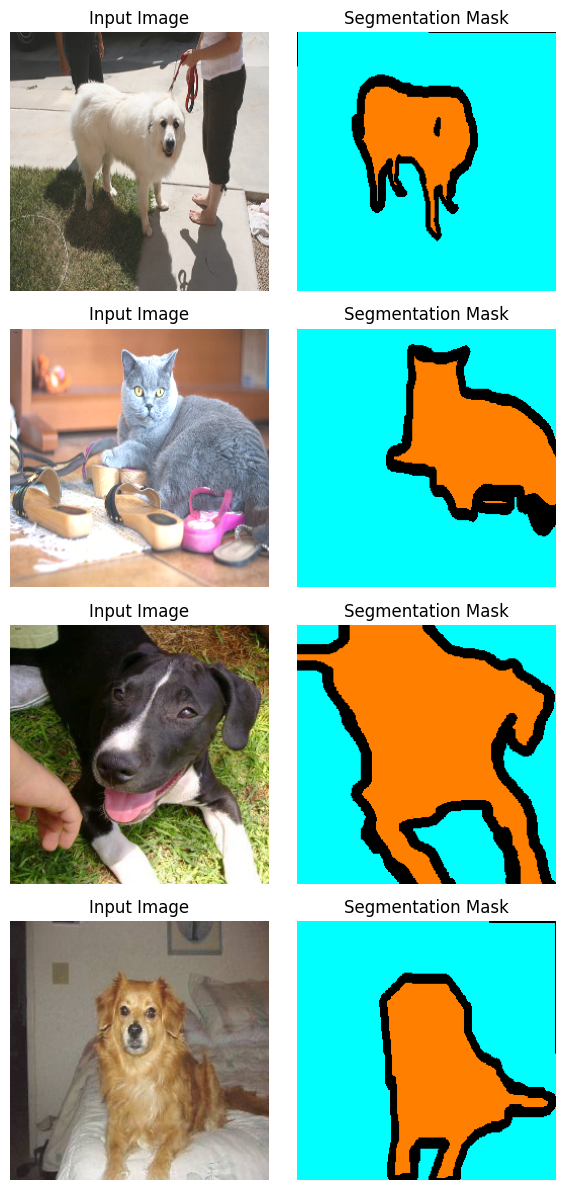

Epoch 1: 100%|██████████| 736/736 [03:21<00:00,  3.66it/s]


Epoch 1: Train Loss=0.6661, Val Loss=0.5184, Pixel Acc=0.7362


Epoch 2: 100%|██████████| 736/736 [03:22<00:00,  3.64it/s]


Epoch 2: Train Loss=0.4722, Val Loss=0.4266, Pixel Acc=0.8176


Epoch 3: 100%|██████████| 736/736 [03:19<00:00,  3.69it/s]


Epoch 3: Train Loss=0.4224, Val Loss=0.3782, Pixel Acc=0.8376


Epoch 4: 100%|██████████| 736/736 [03:21<00:00,  3.64it/s]


Epoch 4: Train Loss=0.3935, Val Loss=0.3836, Pixel Acc=0.8477


Epoch 5: 100%|██████████| 736/736 [03:20<00:00,  3.68it/s]


Epoch 5: Train Loss=0.3667, Val Loss=0.3509, Pixel Acc=0.8596


Epoch 6: 100%|██████████| 736/736 [03:18<00:00,  3.70it/s]


Epoch 6: Train Loss=0.3460, Val Loss=0.3395, Pixel Acc=0.8678


Epoch 7: 100%|██████████| 736/736 [03:20<00:00,  3.67it/s]


Epoch 7: Train Loss=0.3284, Val Loss=0.3324, Pixel Acc=0.8743


Epoch 8: 100%|██████████| 736/736 [03:21<00:00,  3.65it/s]


Epoch 8: Train Loss=0.3174, Val Loss=0.3089, Pixel Acc=0.8789


Epoch 9: 100%|██████████| 736/736 [03:20<00:00,  3.68it/s]


Epoch 9: Train Loss=0.3046, Val Loss=0.3009, Pixel Acc=0.8836


Epoch 10: 100%|██████████| 736/736 [03:17<00:00,  3.72it/s]


Epoch 10: Train Loss=0.2945, Val Loss=0.3277, Pixel Acc=0.8878


Epoch 11: 100%|██████████| 736/736 [03:15<00:00,  3.76it/s]


Epoch 11: Train Loss=0.2846, Val Loss=0.3051, Pixel Acc=0.8918


Epoch 12: 100%|██████████| 736/736 [03:16<00:00,  3.75it/s]


Epoch 12: Train Loss=0.2732, Val Loss=0.2840, Pixel Acc=0.8957


Epoch 13: 100%|██████████| 736/736 [03:17<00:00,  3.72it/s]


Epoch 13: Train Loss=0.2663, Val Loss=0.2806, Pixel Acc=0.8979


Epoch 14: 100%|██████████| 736/736 [03:16<00:00,  3.75it/s]


Epoch 14: Train Loss=0.2579, Val Loss=0.3129, Pixel Acc=0.9006


Epoch 15: 100%|██████████| 736/736 [03:16<00:00,  3.74it/s]


Epoch 15: Train Loss=0.2542, Val Loss=0.2927, Pixel Acc=0.9022


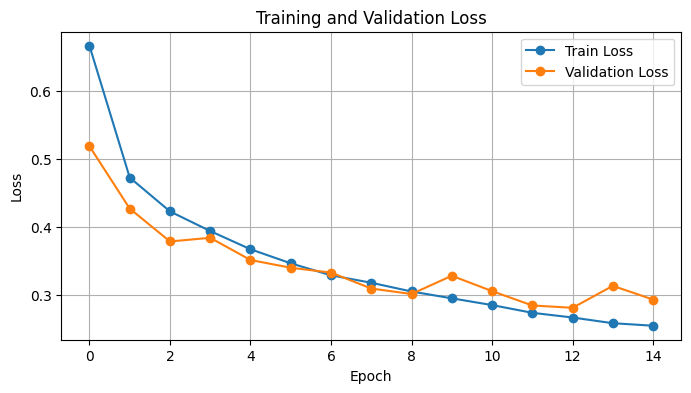

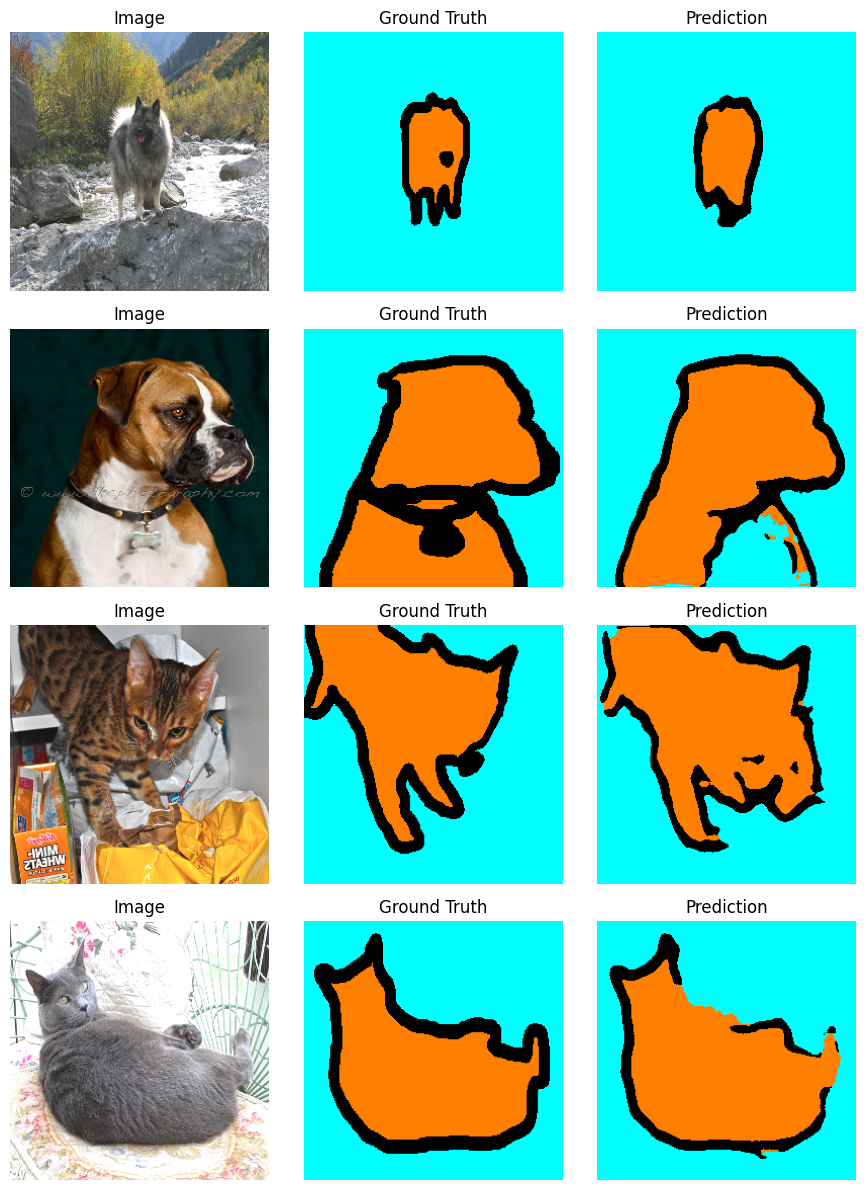

In [1]:
!pip install -q torch torchvision matplotlib numpy pillow tqdm albumentations opencv-python

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import OxfordIIITPet

# -------------------------------------------------
# Reproducibility
# -------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -------------------------------------------------
# Device
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# -------------------------------------------------
# Dataset
# -------------------------------------------------
ROOT = "./data"

base_ds = OxfordIIITPet(
    root=ROOT,
    split="trainval",
    target_types="segmentation",
    download=True
)

IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 15
LR = 1e-4

# -------------------------------------------------
# Classes
# -------------------------------------------------
CLASSES = {
    0: "Background",
    1: "Pet",
    2: "Border"
}

COLORS = {
    0: [0, 0, 0],
    1: [255, 128, 0],
    2: [0, 255, 255]
}

NUM_CLASSES = len(CLASSES)

# -------------------------------------------------
# Dataset Wrapper
# -------------------------------------------------
class SegmentationDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        image = np.array(image)
        mask = np.array(mask)

        mapped_mask = np.zeros_like(mask)
        mapped_mask[mask == 1] = 1   # pet
        mapped_mask[mask == 2] = 2   # border
        mapped_mask[mask == 3] = 0   # background

        if self.transform:
            augmented = self.transform(image=image, mask=mapped_mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

# -------------------------------------------------
# Transforms
# -------------------------------------------------
train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# -------------------------------------------------
# Datasets and Loaders
# -------------------------------------------------
full_ds = SegmentationDataset(base_ds, train_tf)

train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

# -------------------------------------------------
# Utility Functions
# -------------------------------------------------
def decode_mask(mask):
    rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, v in COLORS.items():
        rgb[mask == k] = v
    return rgb

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img.cpu() * std + mean
    return img.clamp(0, 1)

def pixel_accuracy(pred, target):
    return (pred == target).sum().item() / target.numel()

def show_initial_samples(dataset, n=4):
    idxs = random.sample(range(len(dataset)), n)
    fig, axs = plt.subplots(n, 2, figsize=(6, 3*n))

    for i, idx in enumerate(idxs):
        img, mask = dataset[idx]
        axs[i,0].imshow(denormalize(img).permute(1,2,0))
        axs[i,0].set_title("Input Image")
        axs[i,0].axis("off")

        axs[i,1].imshow(decode_mask(mask.numpy()))
        axs[i,1].set_title("Segmentation Mask")
        axs[i,1].axis("off")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Show Initial Samples
# -------------------------------------------------
show_initial_samples(full_ds)

# -------------------------------------------------
# U-Net Model
# -------------------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)

        self.dec4 = DoubleConv(1024, 512)
        self.dec3 = DoubleConv(512, 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)

        self.classifier = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(nn.MaxPool2d(2)(e1))
        e3 = self.enc3(nn.MaxPool2d(2)(e2))
        e4 = self.enc4(nn.MaxPool2d(2)(e3))

        b = self.bottleneck(nn.MaxPool2d(2)(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.classifier(d1)

model = UNet(num_classes=NUM_CLASSES).to(device)

# -------------------------------------------------
# Training Setup
# -------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_loss, val_loss, train_acc = [], [], []

# -------------------------------------------------
# Training Loop
# -------------------------------------------------
for epoch in range(EPOCHS):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        epoch_loss += loss.item()
        epoch_acc += pixel_accuracy(preds, masks)

    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            val_epoch_loss += criterion(model(images), masks).item()

    train_loss.append(epoch_loss / len(train_loader))
    val_loss.append(val_epoch_loss / len(val_loader))
    train_acc.append(epoch_acc / len(train_loader))

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss[-1]:.4f}, "
          f"Val Loss={val_loss[-1]:.4f}, "
          f"Pixel Acc={train_acc[-1]:.4f}")

# -------------------------------------------------
# Loss Curves
# -------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(train_loss, '-o', label="Train Loss")
plt.plot(val_loss, '-o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# Segmentation Results with Object Count
# -------------------------------------------------
def show_segmented_samples(dataset, model, n=4):
    idxs = random.sample(range(len(dataset)), n)
    model.eval()
    fig, axs = plt.subplots(n, 3, figsize=(9, 3*n))

    for i, idx in enumerate(idxs):
        img, gt = dataset[idx]

        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).argmax(1)[0].cpu().numpy()

        axs[i,0].imshow(denormalize(img).permute(1,2,0))
        axs[i,0].set_title("Image")
        axs[i,0].axis("off")

        axs[i,1].imshow(decode_mask(gt.numpy()))
        axs[i,1].set_title("Ground Truth")
        axs[i,1].axis("off")

        axs[i,2].imshow(decode_mask(pred))
        axs[i,2].set_title("Prediction")
        axs[i,2].axis("off")

    plt.tight_layout()
    plt.show()

show_segmented_samples(val_ds, model)

# -------------------------------------------------
# Save Model
# -------------------------------------------------
torch.save(model.state_dict(), "unet_pet_segmentation.pth")